# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Amir Mohammad Ezzati

*SID:* 402212269

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [15]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [16]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/DL/HW2/"

Mounted at /content/drive


## Device

Set device to work with (GPU or CPU)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [18]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [19]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

In [20]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO
        for t, mean, std in zip(tensor, self.mean, self.std):
            t.mul_(std).add_(mean)

        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [21]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [22]:
trainset, valset = train_test_split(initial_trainset, test_size=0.2, random_state=42)

In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False)

In [24]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [25]:
def get_data(dataloader):
  input_tensors = torch.tensor([])
  target_tensors = torch.tensor([])
  for batch_idx, (inputs, targets) in enumerate(dataloader):
      input_tensors = torch.cat((input_tensors, inputs))
      target_tensors = torch.cat((target_tensors, targets))

  return input_tensors, target_tensors

train_img, train_target = get_data(trainloader)

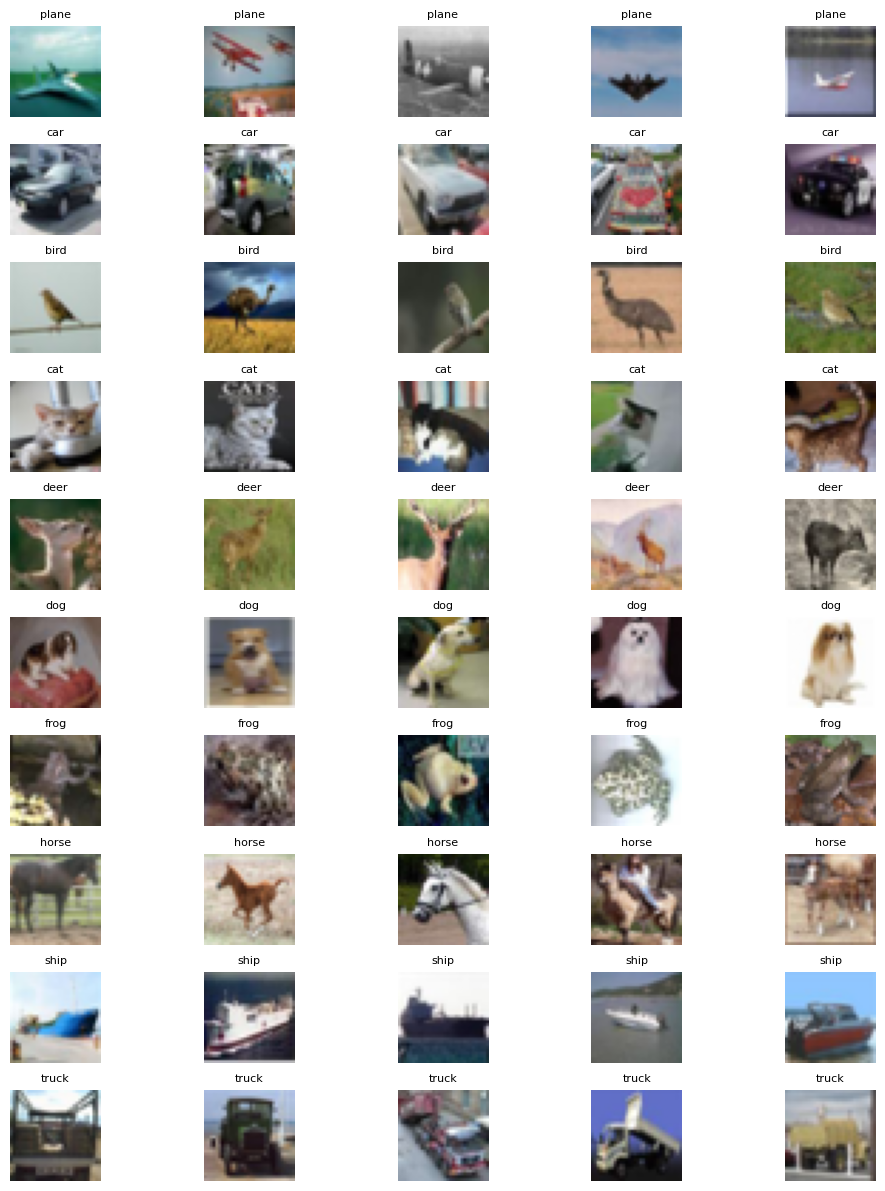

In [26]:
# TODO

W_grid = 5
L_grid = 10
fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()

for i in np.arange(0, L_grid):
    # class == i
    cls_indices = (train_target == i).nonzero(as_tuple=True)[0]
    random_indices = cls_indices[np.random.randint(len(cls_indices), size=5)]

    for j, idx in enumerate(random_indices):
      axes[i*5 + j].imshow(np.transpose(norminv(train_img[idx]), (1, 2, 0)))
      label_index = train_target[idx]
      axes[i*5 + j].set_title(classes[int(label_index)], fontsize = 8)
      axes[i*5 + j].axis('off')

plt.subplots_adjust(hspace=0.3, wspace=-0.5)

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        # 3x3
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet18(torch.nn.Module):
    def __init__(self, resnetBlock, blocks_num, output_classes=10):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.in_channels = 64
        self.b1 = self.addBlocks(resnetBlock, 64, blocks_num[0], stride=1)
        self.b2 = self.addBlocks(resnetBlock, 128, blocks_num[1], stride=2)
        self.b3 = self.addBlocks(resnetBlock, 256, blocks_num[2], stride=2)
        self.b4 = self.addBlocks(resnetBlock, 512, blocks_num[3], stride=2)

        self.linear = nn.Linear(512, output_classes)

    def addBlocks(self, resnetBlock, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(resnetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)

        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
net = ResNet18(ResNetBlock, [2, 2, 2, 2])

net.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm
from time import time

In [ ]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler, dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    scheduler.step()

    loss = running_loss / len(dataloader)
    accuracy = 100. * correct/total
    return loss, accuracy


def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    loss = running_loss / len(dataloader)
    accuracy = 100. * correct/total
    return loss, accuracy


In [ ]:
model_path = data_path + 'resnet18.pt'

epochs = 30

best_valid_loss = float('inf')
best_valid_acc = 0

accuracy_hist, loss_hist = {}, {}
loss_hist['train'], loss_hist['valid'] = [], []
accuracy_hist['train'], accuracy_hist['valid'] = [], []

for e in range(epochs):
  train_loss, train_acc = train_epoch(net, criterion, optimizer, scheduler, trainloader)
  valid_loss, valid_acc = eval_epoch(net, criterion, valloader, test_mode = False)

  loss_hist['train'].append(train_loss)
  loss_hist['valid'].append(valid_loss)
  accuracy_hist['train'].append(train_acc)
  accuracy_hist['valid'].append(valid_acc)

  # Save checkpoint
  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_valid_loss = valid_loss
    torch.save(net.state_dict(), model_path)

  print(f'Epoch [{e+1}/{epochs}] - '
          f'Train Loss: {train_loss:.4f} - '
          f'Train Accuracy: {train_acc:.4f} - '
          f'Valid Loss: {valid_loss:.4f} - '
          f'Valid Accuracy {valid_acc:.4f}%')

Epoch [1/30] - Train Loss: 1.4025 - Train Accuracy: 48.9475 - Valid Loss: 1.1599 - Valid Accuracy 57.7100%
Epoch [2/30] - Train Loss: 0.9000 - Train Accuracy: 67.6375 - Valid Loss: 0.8146 - Valid Accuracy 71.5000%
Epoch [3/30] - Train Loss: 0.6595 - Train Accuracy: 76.8350 - Valid Loss: 0.7604 - Valid Accuracy 74.4000%
Epoch [4/30] - Train Loss: 0.5029 - Train Accuracy: 82.3825 - Valid Loss: 0.6480 - Valid Accuracy 77.8100%
Epoch [5/30] - Train Loss: 0.3804 - Train Accuracy: 86.8150 - Valid Loss: 0.6369 - Valid Accuracy 79.1400%
Epoch [6/30] - Train Loss: 0.2739 - Train Accuracy: 90.4600 - Valid Loss: 0.6817 - Valid Accuracy 79.1900%
Epoch [7/30] - Train Loss: 0.1772 - Train Accuracy: 93.7850 - Valid Loss: 0.6596 - Valid Accuracy 80.4100%
Epoch [8/30] - Train Loss: 0.1049 - Train Accuracy: 96.4400 - Valid Loss: 0.7412 - Valid Accuracy 80.5000%
Epoch [9/30] - Train Loss: 0.0608 - Train Accuracy: 98.0225 - Valid Loss: 0.6912 - Valid Accuracy 82.6100%
Epoch [10/30] - Train Loss: 0.0289 - 

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

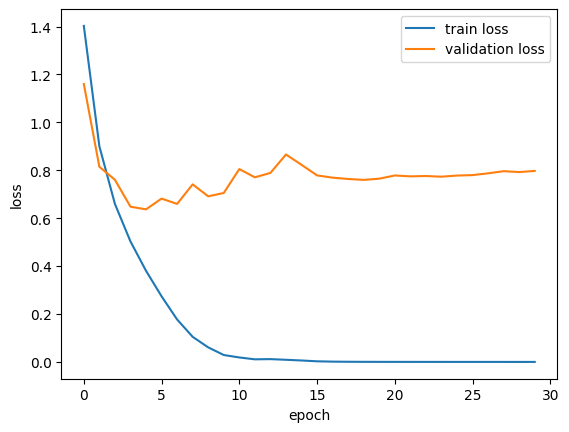

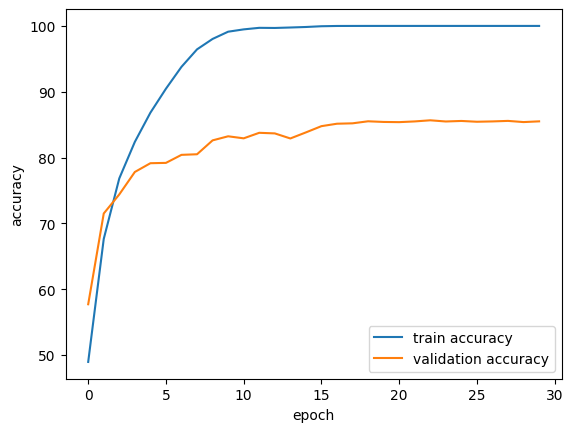

In [ ]:
# TODO

def plot(history, metric='accuracy'):
  epochs = np.arange(len(history['train']))
  plt.plot(epochs, history['train'], label='train ' + metric)
  plt.plot(epochs, history['valid'], label='validation ' + metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

plot(loss_hist, 'loss')
plot(accuracy_hist, 'accuracy')

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
# hook for getting feature space of images
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] =  F.avg_pool2d(output.detach(), 4).view(output.size(0), -1)
    return hook

In [ ]:
net = ResNet18(ResNetBlock, [2,2,2,2])

model_path = data_path + 'resnet18.pt'
net.load_state_dict(torch.load(model_path)) # , map_location=torch.device('cpu')

net.b4[1].shortcut.register_forward_hook(get_activation('feature-space'))
net.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
# TODO
test_loss, test_acc = eval_epoch(net, criterion, testloader, test_mode = True)

print(f'Test Loss: {test_loss:.4f} - '
      f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.8049 - Test Accuracy: 85.3000


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

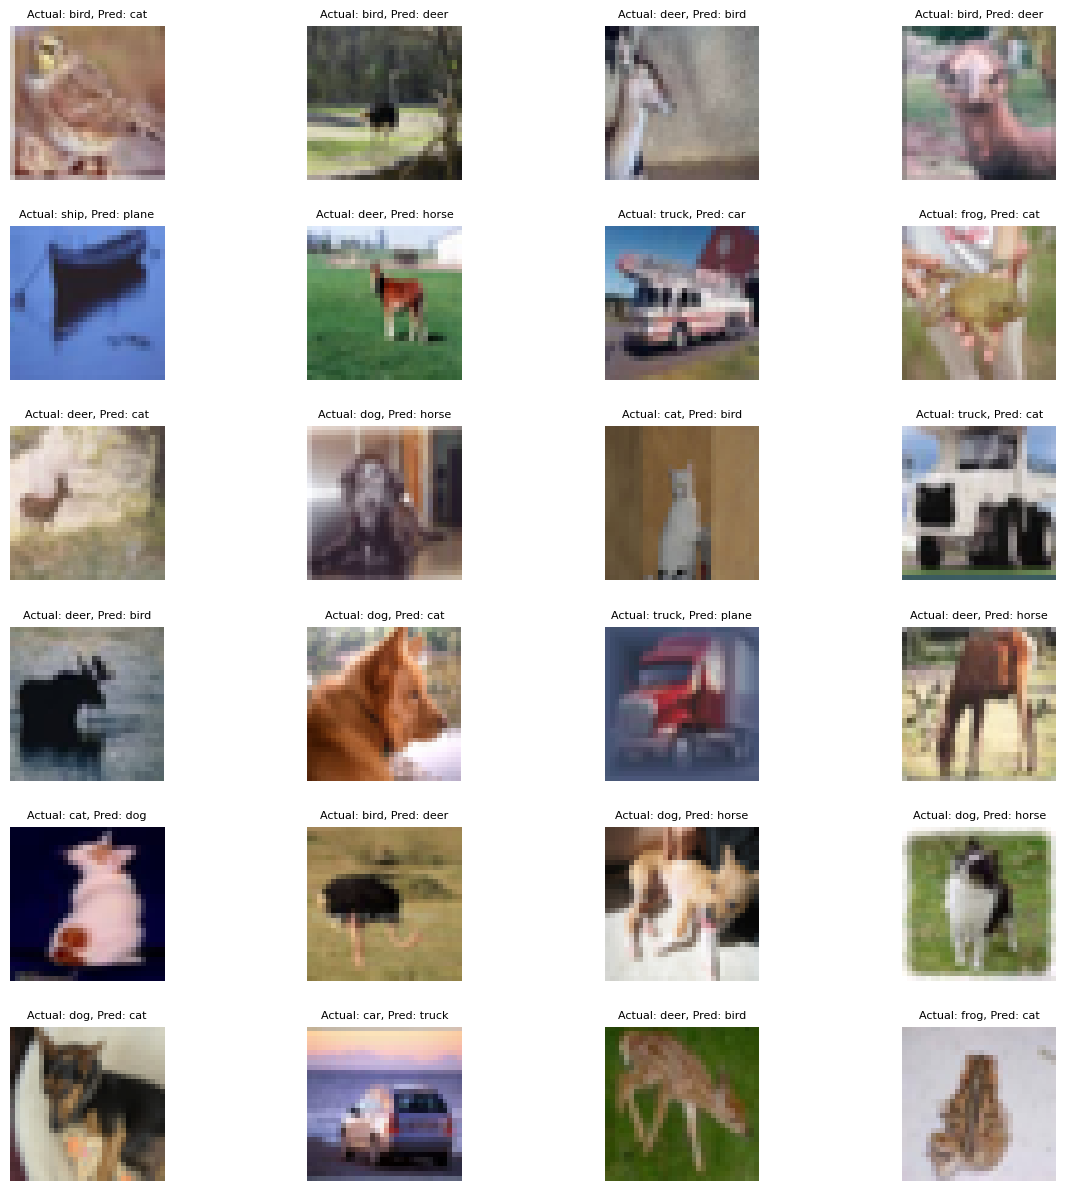

In [ ]:
# TODO
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_incorrect(net, dataloader):
  incorrect_samples = []
  for batch_idx, (inputs, targets) in enumerate(dataloader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      _, predicted = outputs.max(1)
      incorrets_indices = ( (((predicted == targets) == False) * (targets+1) - 1) >= 0 ).nonzero(as_tuple=True)[0]
      incorrect_samples.extend(zip(inputs[incorrets_indices].cpu(), targets[incorrets_indices].cpu(), predicted[incorrets_indices].cpu()))

  W_grid = 4
  L_grid = 6
  fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))

  axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
  n_train = len(trainset)
  for i in np.arange(0, W_grid * L_grid):
      index = np.random.randint(0, len(incorrect_samples))

      axes[i].imshow(np.transpose(norminv(incorrect_samples[index][0]), (1, 2, 0)))
      label_gt = incorrect_samples[index][1]
      label_pred = incorrect_samples[index][2]
      axes[i].set_title(f'Actual: {classes[label_gt]}, Pred: {classes[label_pred]}', fontsize = 8)
      axes[i].axis('off')

  plt.subplots_adjust(hspace=0.3, wspace=0.1)


plot_incorrect(net, testloader)

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
# TODO
trainloader_all = torch.utils.data.DataLoader(initial_trainset, batch_size=128, shuffle=True)


def get_featureSpace(net, dataloader):
  input_tensors = torch.tensor([])
  target_tensors = torch.tensor([])
  feature_spaces = torch.tensor([])
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(dataloader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = net(inputs)
          feature_spaces = torch.cat((feature_spaces, activation['feature-space'].cpu()))
          input_tensors = torch.cat((input_tensors, inputs.cpu()))
          target_tensors = torch.cat((target_tensors, targets.cpu()))

  return feature_spaces, input_tensors, target_tensors

feature_spaces, input_tensors, target_tensors = get_featureSpace(net, trainloader_all)
feature_spaces.shape

torch.Size([50000, 512])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

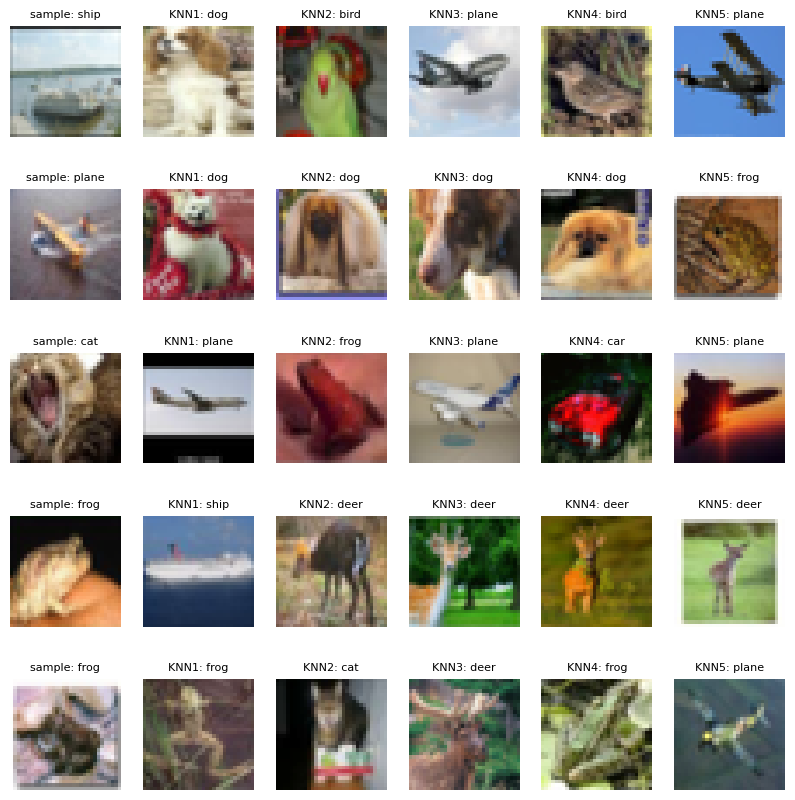

In [ ]:
# TODO

def get_correct(net, dataloader):
  correct_samples = []
  for batch_idx, (inputs, targets) in enumerate(dataloader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      _, predicted = outputs.max(1)
      correts_indices = ( ((predicted == targets) * (targets+1) - 1) >= 0 ).nonzero(as_tuple=True)[0]
      correct_samples.extend(zip(inputs[correts_indices].cpu(), targets[correts_indices].cpu()))

  return correct_samples


def findKNN(sample, feature_spaces):
  feature_spaces_norm = torch.linalg.norm(feature_spaces, dim=1)

  outputs = net(sample.to(device).unsqueeze(0))
  sample_fs = activation['feature-space'][0].cpu()

  abs_distance = torch.abs(feature_spaces_norm - torch.linalg.norm(sample_fs))
  return torch.topk(abs_distance, k=5, largest=False).indices # indices of KNN


np.random.seed(seed=21)
correct_samples = get_correct(net, testloader)
random_indices = np.random.randint(len(correct_samples), size=5)


fig, axs = plt.subplots(5, 6, figsize=(10, 10))
for i in range(len(random_indices)):
  sample, target = correct_samples[random_indices[i]]
  knn_indices = findKNN(sample, feature_spaces)

  axs[i, 0].imshow(np.transpose(norminv(sample), (1, 2, 0)))
  axs[i, 0].set_title(f'sample: {classes[target]}', fontsize = 8)
  axs[i, 0].axis('off')

  for j in range(1, 6):
    axs[i, j].imshow(np.transpose(norminv(input_tensors[knn_indices[j-1]]), (1, 2, 0)))
    axs[i, j].set_title(f'KNN{j}: {classes[int(target_tensors[knn_indices[j-1]])]}', fontsize = 8)
    axs[i, j].axis('off')

plt.subplots_adjust(hspace=0.4)

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


In [ ]:
indices = np.random.randint(len(feature_spaces), size=2000)

m_samples = feature_spaces[indices]
m_targets = target_tensors[indices]

In [ ]:
# TODO
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 0)
print(m_samples.shape)
tsne_data = tsne.fit_transform(m_samples)
print(tsne_data.shape)

torch.Size([2000, 512])
(2000, 2)


<Figure size 640x480 with 0 Axes>

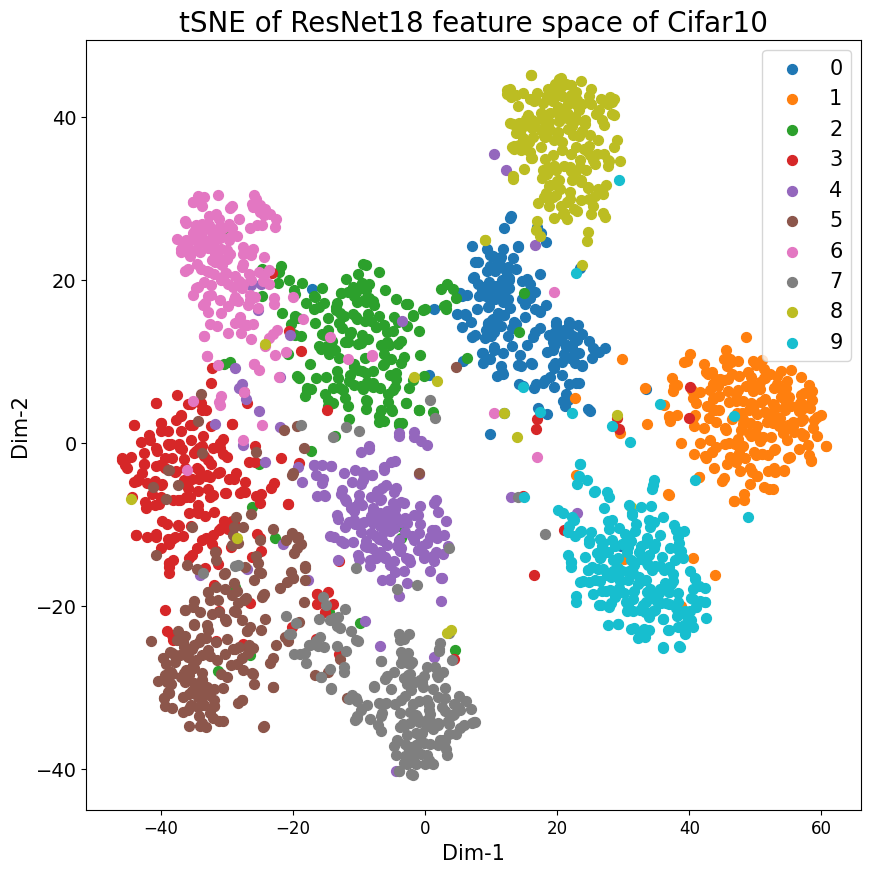

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Dim-1', fontsize=15)
plt.ylabel('Dim-2', fontsize=15)
plt.title("tSNE of ResNet18 feature space of Cifar10", fontsize=20)
classes = np.arange(10)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for cls, color in zip(classes, colors):
    indicesToKeep = (m_targets == cls).nonzero(as_tuple=True)[0]
    plt.scatter(tsne_data[indicesToKeep, 0], tsne_data[indicesToKeep, 1], c=color, s=50)

plt.legend(classes, prop={'size': 15})

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [28]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [30]:
from skimage.color import rgb2gray

class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
      self.rgbdata = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)


    def __len__(self):
        return len(self.rgbdata)

    def __getitem__(self, index):
      rgbimg = self.rgbdata[index][0]
      rgbimg_ = torch.permute(rgbimg, (1, 2, 0)) # change order of shape
      grayimg = rgb2gray(rgbimg_)

      grayimg = torch.from_numpy(grayimg).reshape((1, rgbimg.shape[1], rgbimg.shape[2]))

      return grayimg, rgbimg


## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [31]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [32]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

In [33]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [34]:
trainset, valset = train_test_split(initial_trainset, test_size=0.2, random_state=42)

In [35]:
trainset[0][1].shape

torch.Size([3, 32, 32])

In [36]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

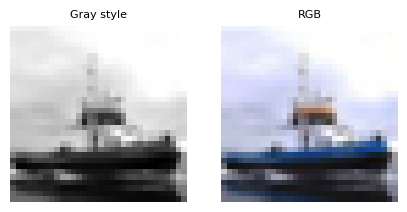

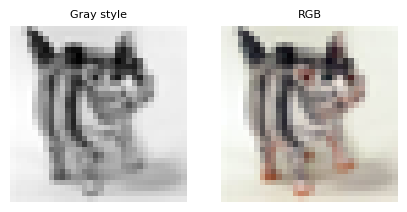

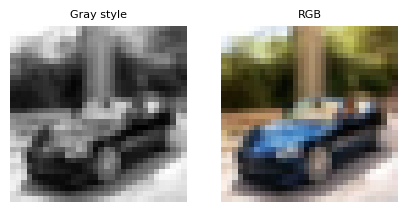

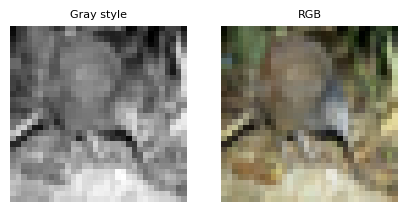

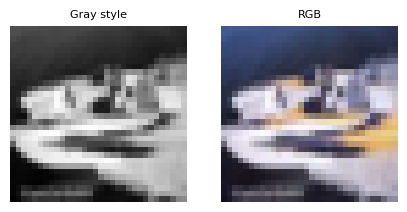

In [37]:
# TODO
num = 5

for i in range(num):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 5))

    index = np.random.randint(0, len(trainset))
    ax1.imshow(np.transpose(norminv(trainset[index][0]), (1, 2, 0)), cmap='gray')
    ax1.set_title("Gray style", fontsize = 8)
    ax1.axis('off')

    ax2.imshow(np.transpose(norminv(trainset[index][1]), (1, 2, 0)))
    ax2.set_title("RGB", fontsize = 8)
    ax2.axis('off')

    plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [38]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.layers(x)
        return out

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip_input):
        out = self.layers(x)
        out = torch.cat((skip_input, out), dim=1)
        return out


class colorizationNet(nn.Module):
    def __init__(self, in_channel=1, out_channel=3):
      super(colorizationNet, self).__init__()

      n1 = 64
      filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

      self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.Conv1 = ConvBlock(in_channel, filters[0])
      self.Conv2 = ConvBlock(filters[0], filters[1])
      self.Conv3 = ConvBlock(filters[1], filters[2])
      self.Conv4 = ConvBlock(filters[2], filters[3])

      self.Conv5 = ConvBlock(filters[3], filters[4])

      self.TransConv4 = TransConvBlock(filters[4], filters[3])
      self.Up_conv4 = ConvBlock(filters[4], filters[3])

      self.TransConv3 = TransConvBlock(filters[3], filters[2])
      self.Up_conv3 = ConvBlock(filters[3], filters[2])

      self.TransConv2 = TransConvBlock(filters[2], filters[1])
      self.Up_conv2 = ConvBlock(filters[2], filters[1])

      self.TransConv1 = TransConvBlock(filters[1], filters[0])
      self.Up_conv1 = ConvBlock(filters[1], filters[0])

      self.Conv = nn.Conv2d(filters[0], out_channel, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

      e1 = self.Conv1(x)

      e2 = self.Maxpool1(e1)
      e2 = self.Conv2(e2)

      e3 = self.Maxpool2(e2)
      e3 = self.Conv3(e3)

      e4 = self.Maxpool3(e3)
      e4 = self.Conv4(e4)

      e5 = self.Maxpool4(e4)
      e5 = self.Conv5(e5)

      d4 = self.TransConv4(e5, e4)
      d4 = self.Up_conv4(d4)

      d3 = self.TransConv3(d4, e3)
      d3 = self.Up_conv3(d3)

      d2 = self.TransConv2(d3, e2)
      d2 = self.Up_conv2(d2)

      d1 = self.TransConv1(d2, e1)
      d1 = self.Up_conv1(d1)

      out = self.Conv(d1)

      return out


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [39]:
net = colorizationNet()

net.to(device)

colorizationNet(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): ConvBlock(
    (layers): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): ConvBlock(
    (layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=

In [40]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [41]:
import tqdm
from time import time

In [42]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss = running_loss / len(dataloader)
    return loss

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()

    loss = running_loss / len(dataloader)
    return loss

In [43]:
model_path = data_path + 'colorizerUNet.pt'

epochs = 20

best_valid_loss = float('inf')

loss_hist = {}
loss_hist['train'], loss_hist['valid'] = [], []
for e in range(epochs):
    train_loss = train_epoch(net, criterion, optimizer, trainloader)
    valid_loss = eval_epoch(net, criterion, valloader, test_mode=False)

    # Save checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), model_path)

    loss_hist['train'].append(train_loss)
    loss_hist['valid'].append(valid_loss)

    print(f'Epoch [{e+1}/{epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Valid Loss: {valid_loss:.4f}')

Epoch [1/20] - Train Loss: 0.1723 - Valid Loss: 0.1414
Epoch [2/20] - Train Loss: 0.1414 - Valid Loss: 0.1362
Epoch [3/20] - Train Loss: 0.1383 - Valid Loss: 0.1309
Epoch [4/20] - Train Loss: 0.1362 - Valid Loss: 0.1342
Epoch [5/20] - Train Loss: 0.1348 - Valid Loss: 0.1346
Epoch [6/20] - Train Loss: 0.1329 - Valid Loss: 0.1267
Epoch [7/20] - Train Loss: 0.1314 - Valid Loss: 0.1298
Epoch [8/20] - Train Loss: 0.1300 - Valid Loss: 0.1266
Epoch [9/20] - Train Loss: 0.1282 - Valid Loss: 0.1275
Epoch [10/20] - Train Loss: 0.1266 - Valid Loss: 0.1254
Epoch [11/20] - Train Loss: 0.1254 - Valid Loss: 0.1235
Epoch [12/20] - Train Loss: 0.1238 - Valid Loss: 0.1261
Epoch [13/20] - Train Loss: 0.1221 - Valid Loss: 0.1280
Epoch [14/20] - Train Loss: 0.1189 - Valid Loss: 0.1270
Epoch [15/20] - Train Loss: 0.1158 - Valid Loss: 0.1227
Epoch [16/20] - Train Loss: 0.1133 - Valid Loss: 0.1247
Epoch [17/20] - Train Loss: 0.1091 - Valid Loss: 0.1248
Epoch [18/20] - Train Loss: 0.1048 - Valid Loss: 0.1258
E

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

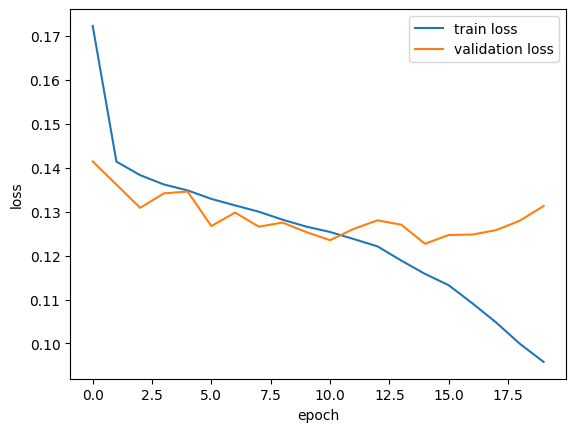

In [44]:
# TODO

def plot(history, metric='loss'):
  epochs = np.arange(len(history['train']))
  plt.plot(epochs, history['train'], label='train ' + metric)
  plt.plot(epochs, history['valid'], label='validation ' + metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

plot(loss_hist, 'loss')

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [ ]:
net = colorizationNet()
net.to(device)

model_path = data_path + 'colorizerUNet.pt'
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
testset = BlackAndWhiteCIFAR10(root='./data', train=False,
                                download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified


In [ ]:
# TODO
test_loss = eval_epoch(net, criterion, testloader, test_mode=True)
test_loss

0.12244977783175963

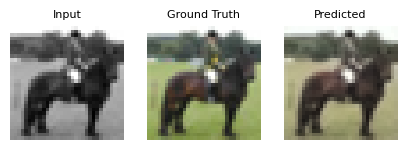

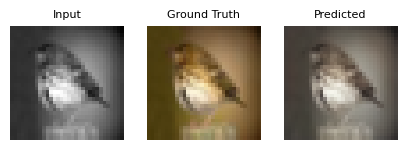

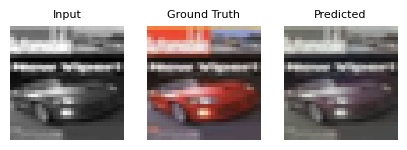

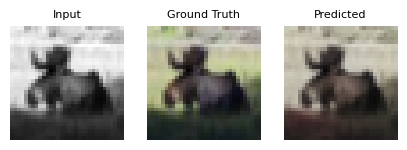

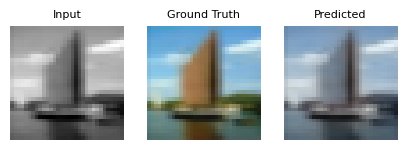

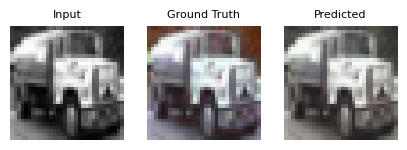

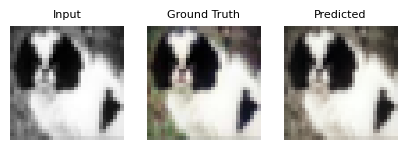

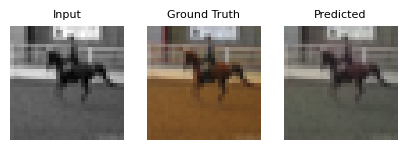

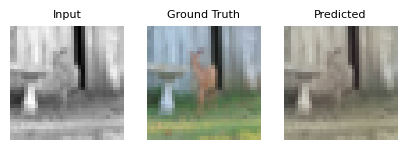

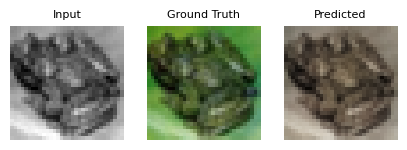

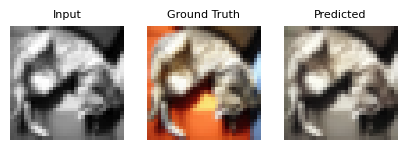

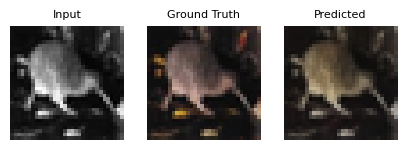

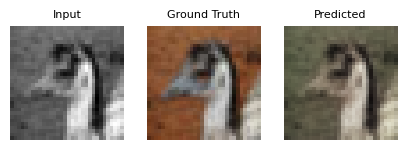

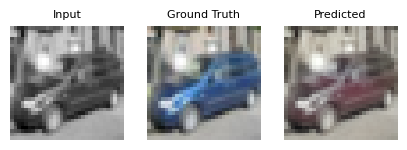

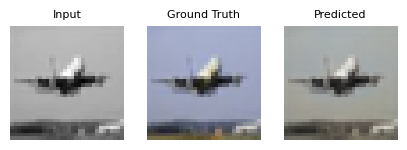

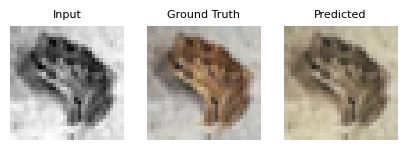

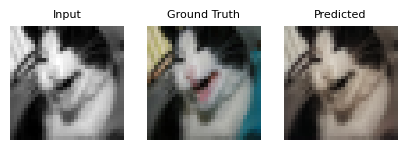

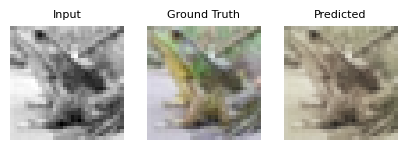

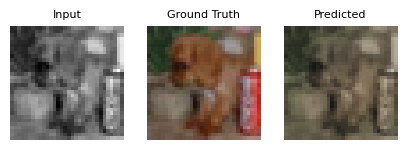

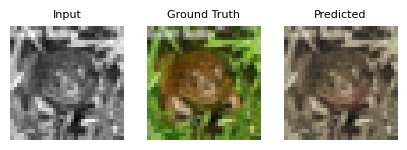

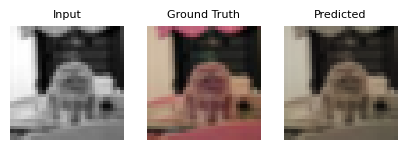

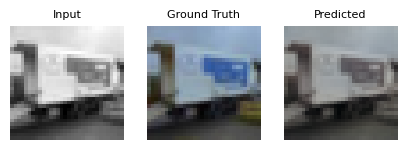

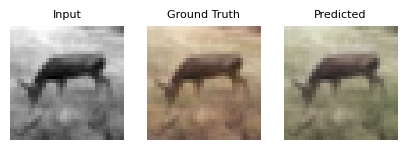

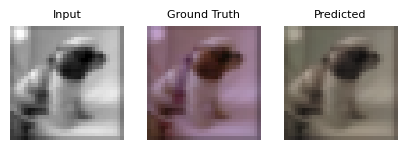

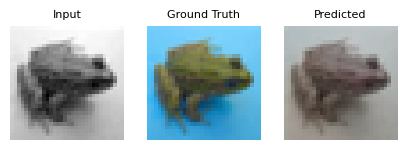

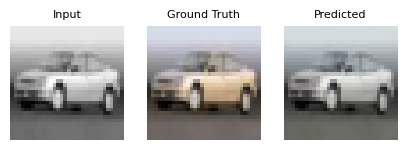

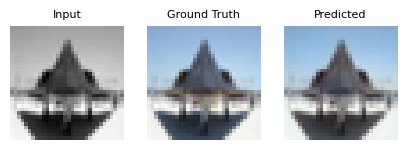

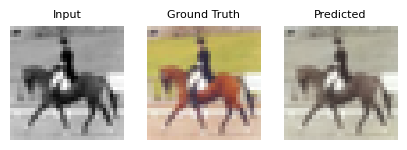

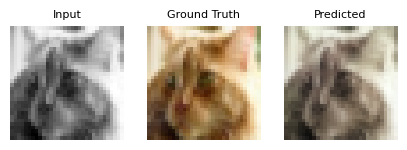

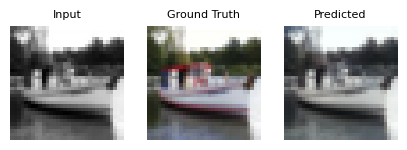

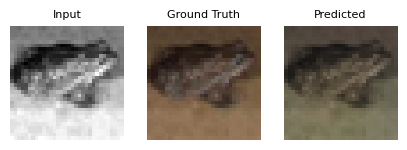

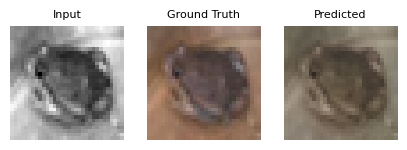

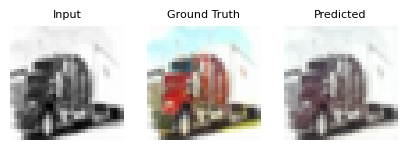

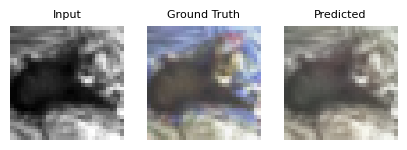

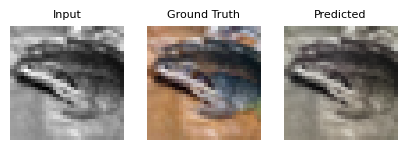

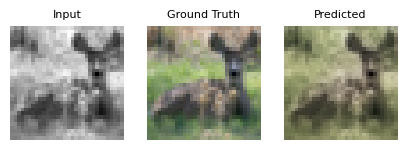

In [ ]:
num = 36

for i in range(num):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (5, 5))

    index = np.random.randint(0, len(testset))
    ax1.imshow(np.transpose(norminv(testset[index][0]), (1, 2, 0)), cmap='gray')
    ax1.set_title("Input", fontsize = 8)
    ax1.axis('off')

    ax2.imshow(np.transpose(norminv(testset[index][1]), (1, 2, 0)))
    ax2.set_title("Ground Truth", fontsize = 8)
    ax2.axis('off')

    predicted = net(torch.unsqueeze(testset[index][0], 0).to(device))[0].cpu().detach()
    ax3.imshow(np.transpose(norminv(predicted), (1, 2, 0)))
    ax3.set_title("Predicted", fontsize = 8)
    ax3.axis('off')

    plt.show()